In [1]:
import gzip
import pandas as pd
import os
from collections import defaultdict
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
import ast
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = os.getcwd()

# Print path
print(path)



c:\Users\fried\Desktop\Project_emerson


#### 1. Read all the patient files and make a dictionary where key = combination, value = list of reperoire_ids

In [3]:
# Path of file
files_path = path + '\\data\\HLA_emerson_2017'

all_files = os.listdir(files_path)

tsv_gz_files = [f for f in all_files if f.endswith('.tsv.gz')]

tsv_gz_files = tsv_gz_files[:400]

patient_names = [f.split('.')[0] for f in tsv_gz_files]
#print(patient_names)

In [3]:
#read patient file
dataframes = []

clonotype_occurences = defaultdict(set)

for f in tsv_gz_files:
    file_path = os.path.join(files_path, f)
    with gzip.open(file_path, 'rt') as fi:
        # Inlezen als pandas DataFrame
        df = pd.read_csv(fi, sep='\t')
        
        for row in df.itertuples(index=False):
            combination = (row.v_call, row.junction_aa, row.j_call)
            rep_id = row.repertoire_id
            clonotype_occurences[combination].add(rep_id)
            
        


In [4]:
print(len(clonotype_occurences))

44768327


In [5]:
tcr_df = pd.DataFrame(list(clonotype_occurences.items()), columns=['combination', 'repertoire_ids'])

In [6]:
tcr_df = tcr_df[tcr_df['repertoire_ids'].apply(len) >= 5]
tcr_df.reset_index(drop=True, inplace=True)
tcr_df

,combination,repertoire_ids
0,"(TRBV5-1, CASSLRGSGNTIYF, TRBJ1-3)","{P00103_clonotypes, P00241_clonotypes, P00356_..."
1,"(TRBV4-2, CASSQEGQSSYEQYF, TRBJ2-7)","{P00001_clonotypes, P00017_clonotypes, P00008_..."
2,"(TRBV6-5, CASSYSGSNQPQHF, TRBJ1-5)","{P00247_clonotypes, P00113_clonotypes, P00356_..."
3,"(TRBV6-5, CASSYYGTAQETQYF, TRBJ2-5)","{P00001_clonotypes, P00126_clonotypes, P00003_..."
4,"(TRBV6-4, CASSDNSGANVLTF, TRBJ2-6)","{P00054_clonotypes, P00325_clonotypes, P00331_..."
...,...,...
1007240,"(TRBV5-1, CASSLSGQNEKLFF, TRBJ1-4)","{P00384_clonotypes, P00351_clonotypes, P00357_..."
1007241,"(TRBV7-6, CASSLAGPSSGNTIYF, TRBJ1-3)","{P00384_clonotypes, P00385_clonotypes, P00352_..."
1007242,"(TRBV12-5, CASGHQETQYF, TRBJ2-5)","{P00368_clonotypes, P00367_clonotypes, P00353_..."
1007243,"(TRBV18, CASSPTGIYNEQFF, TRBJ2-1)","{P00397_clonotypes, P00368_clonotypes, P00373_..."


In [7]:
# # Wegschrijven naar een TSV-bestand
tcr_df.to_csv('results\\tcr_df_output.tsv', sep='\t', index=False)  # sep='\t' voor TSV


In [4]:
# Inlezen van het TSV-bestand
tcr_df = pd.read_csv(path + "\\results\\tcr_df_output.tsv", sep='\t')
tcr_df['repertoire_ids'] = tcr_df['repertoire_ids'].apply(ast.literal_eval)


#### 2. Match the HLA-labelling with the patient files (A_02_01_features.txt contains the indices to the patient files)

In [42]:
# Filepath to your text file
file_path = path + '\\data\\A_02_01_features.txt'

files_path = path + '\\data\\HLA_emerson_2017'

all_files = os.listdir(files_path)

tsv_gz_files_validation = [f for f in all_files if f.endswith('.tsv.gz')]
all_patient_names = [f.split('.')[0] for f in tsv_gz_files_validation]


record =  {}  # Temporary dictionary to hold one record
# Read and parse the file
with open(file_path, "r") as file:
    for line in file:
        line = line.split(" ")
        if line[1] == 'HLA-A*02:01':
            key = line[2]
            for i in range(5, len(line)):
                value = line[i]
                if value == '\n':
                    continue
                ## value is the index to the patient file
                patient = all_patient_names[int(value)]
                if key in ['num_positives:']:
                    record[patient] = True
                elif key in ['num_negatives:']:
                    record[patient] = False   


for patient in all_patient_names:
    if patient not in record.keys():
        record[patient] = None

patient_df = pd.DataFrame(list(record.items()), columns=['repertoire_id', 'has_HLA_A02_01'])
patient_df.sort_values(by=['repertoire_id'], inplace=True, ignore_index=True)
patient_df.head(10)

,repertoire_id,has_HLA_A02_01
0,P00001_clonotypes,False
1,P00002_clonotypes,True
2,P00003_clonotypes,True
3,P00004_clonotypes,True
4,P00005_clonotypes,False
5,P00006_clonotypes,True
6,P00007_clonotypes,True
7,P00008_clonotypes,True
8,P00009_clonotypes,False
9,P00010_clonotypes,True


In [43]:
print(len(patient_df))

666


In [44]:
# Select the first 400 patients and remove the rows with None
patient_df_filtered = patient_df.iloc[:400]
patient_df_filtered = patient_df_filtered[patient_df_filtered['has_HLA_A02_01'].notna()]
patient_df_filtered.reset_index(drop=True, inplace=True)
patient_df_filtered.head(10)
print(len(patient_df_filtered))

372


#### 3. Fisher_exact test for HLA A02:01

#### Make a dataframe where every row contains the TCR (combination), the p-value and odds ratio of fisher_exact method

##### Use a pseudocount of 0.1

In [45]:
# Lijst voor het opslaan van de resultaten
fisher_exact_results = []
for index, row in tcr_df.iterrows():
    # Haal de eerste rij van tcr_df en zijn combinatie en repertoire_ids
    repertoire_ids = row['repertoire_ids']  # Aangenomen dat repertoire_ids een lijst is
    combination = row['combination']


    # Filter patient_df_filtered op basis van de repertoire_ids
    filtered_patients = patient_df_filtered[patient_df_filtered['repertoire_id'].isin(repertoire_ids)]


    # Tel het aantal patiënten in elke categorie
    have_hla_and_tcr = len(filtered_patients[filtered_patients['has_HLA_A02_01'] == True]) + 0.1  # Aantal met HLA en TCR
    have_no_hla_and_tcr = len(filtered_patients[filtered_patients['has_HLA_A02_01'] == False]) + 0.1  # Aantal zonder HLA maar met TCR


    # Aantal patiënten zonder TCR
    have_hla_no_tcr = len(patient_df_filtered[(patient_df_filtered['has_HLA_A02_01'] == True) & 
                                               (~patient_df_filtered['repertoire_id'].isin(repertoire_ids))]) + 0.1
    have_no_hla_no_tcr = len(patient_df_filtered[(patient_df_filtered['has_HLA_A02_01'] == False) & 
                                                  (~patient_df_filtered['repertoire_id'].isin(repertoire_ids))]) + 0.1

    # Maak de 2x2-contingentietabel
    contingency_table = [
        [
            have_hla_and_tcr,  # a: patiënten met zowel HLA als TCR
            have_no_hla_and_tcr  # b: patiënten zonder HLA maar met TCR
        ],
        [
            have_hla_no_tcr,  # c: patiënten met HLA maar zonder TCR
            have_no_hla_no_tcr  # d: patiënten zonder HLA en zonder TCR
        ]
    ]


    # Voer de Fisher's Exact Test uit
    odds_ratio, p_value = fisher_exact(contingency_table)

    # Voeg de resultaten toe aan de lijst
    fisher_exact_results.append({
        'HLA': 'HLA-A*02:01',
        'TCR': combination,
        'odds_ratio': odds_ratio,
        'p_value': p_value,
        'have_hla_and_tcr' : have_hla_and_tcr,
        'have_no_hla_and_tcr': have_no_hla_and_tcr,
        'have_hla_no_tcr': have_hla_no_tcr,
        'have_no_hla_no_tcr': have_no_hla_no_tcr
    })

# Zet de resultaten om in een DataFrame
fisher_exact_results_df = pd.DataFrame(fisher_exact_results)


In [46]:
fisher_exact_results_df

,HLA,TCR,odds_ratio,p_value,have_hla_and_tcr,have_no_hla_and_tcr,have_hla_no_tcr,have_no_hla_no_tcr
0,HLA-A*02:01,"('TRBV5-1', 'CASSLRGSGNTIYF', 'TRBJ1-3')",1.168750,0.633815,21.1,24.1,140.1,187.1
1,HLA-A*02:01,"('TRBV4-2', 'CASSQEGQSSYEQYF', 'TRBJ2-7')",0.982258,1.000000,6.1,8.1,155.1,203.1
2,HLA-A*02:01,"('TRBV6-5', 'CASSYSGSNQPQHF', 'TRBJ1-5')",0.970109,0.916120,69.1,92.1,92.1,119.1
3,HLA-A*02:01,"('TRBV6-5', 'CASSYYGTAQETQYF', 'TRBJ2-5')",0.650943,0.701900,2.1,4.1,159.1,207.1
4,HLA-A*02:01,"('TRBV6-4', 'CASSDNSGANVLTF', 'TRBJ2-6')",0.946849,0.830762,62.1,84.1,99.1,127.1
...,...,...,...,...,...,...,...,...
1007240,HLA-A*02:01,"('TRBV5-1', 'CASSLSGQNEKLFF', 'TRBJ1-4')",1.314465,1.000000,2.1,2.1,159.1,209.1
1007241,HLA-A*02:01,"('TRBV7-6', 'CASSLAGPSSGNTIYF', 'TRBJ1-3')",0.000000,0.136572,0.1,4.1,161.1,207.1
1007242,HLA-A*02:01,"('TRBV12-5', 'CASGHQETQYF', 'TRBJ2-5')",1.984177,0.655966,3.1,2.1,158.1,209.1
1007243,HLA-A*02:01,"('TRBV18', 'CASSPTGIYNEQFF', 'TRBJ2-1')",0.872117,1.000000,2.1,3.1,159.1,208.1


In [47]:
# Neem de -log10 van de p-value en de log2 van de odds_ratio en voeg ze toe aan de DataFrame
fisher_exact_results_df['log2_odds_ratio'] = np.log2(fisher_exact_results_df['odds_ratio'])
fisher_exact_results_df['neg_log10_p_value'] = -np.log10(fisher_exact_results_df['p_value'])

# Bekijk de bijgewerkte DataFrame
fisher_exact_results_df

c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,HLA,TCR,odds_ratio,p_value,have_hla_and_tcr,have_no_hla_and_tcr,have_hla_no_tcr,have_no_hla_no_tcr,log2_odds_ratio,neg_log10_p_value
0,HLA-A*02:01,"('TRBV5-1', 'CASSLRGSGNTIYF', 'TRBJ1-3')",1.168750,0.633815,21.1,24.1,140.1,187.1,0.224966,0.198038
1,HLA-A*02:01,"('TRBV4-2', 'CASSQEGQSSYEQYF', 'TRBJ2-7')",0.982258,1.000000,6.1,8.1,155.1,203.1,-0.025826,-0.000000
2,HLA-A*02:01,"('TRBV6-5', 'CASSYSGSNQPQHF', 'TRBJ1-5')",0.970109,0.916120,69.1,92.1,92.1,119.1,-0.043782,0.038047
3,HLA-A*02:01,"('TRBV6-5', 'CASSYYGTAQETQYF', 'TRBJ2-5')",0.650943,0.701900,2.1,4.1,159.1,207.1,-0.619396,0.153725
4,HLA-A*02:01,"('TRBV6-4', 'CASSDNSGANVLTF', 'TRBJ2-6')",0.946849,0.830762,62.1,84.1,99.1,127.1,-0.078793,0.080523
...,...,...,...,...,...,...,...,...,...,...
1007240,HLA-A*02:01,"('TRBV5-1', 'CASSLSGQNEKLFF', 'TRBJ1-4')",1.314465,1.000000,2.1,2.1,159.1,209.1,0.394476,-0.000000
1007241,HLA-A*02:01,"('TRBV7-6', 'CASSLAGPSSGNTIYF', 'TRBJ1-3')",0.000000,0.136572,0.1,4.1,161.1,207.1,-inf,0.864640
1007242,HLA-A*02:01,"('TRBV12-5', 'CASGHQETQYF', 'TRBJ2-5')",1.984177,0.655966,3.1,2.1,158.1,209.1,0.988541,0.183119
1007243,HLA-A*02:01,"('TRBV18', 'CASSPTGIYNEQFF', 'TRBJ2-1')",0.872117,1.000000,2.1,3.1,159.1,208.1,-0.197406,-0.000000


In [48]:
# Voeg een kolom toe om te controleren of de p-value kleiner is dan 0.05
fisher_exact_results_df['significant'] = fisher_exact_results_df['p_value'] < 0.05


In [49]:
# Wegschrijven naar een TSV-bestand
fisher_exact_results_df.to_csv('results\\fisher_exact_results.tsv', sep='\t', index=False)  # sep='\t' voor TSV

In [50]:
# Inlezen van het TSV-bestand
fisher_exact_results_df = pd.read_csv(path + "\\results\\fisher_exact_results.tsv", sep='\t')
fisher_exact_results_df['TCR'] = fisher_exact_results_df['TCR'].apply(ast.literal_eval)

In [54]:
## Bij fisher exact test: in tabel bij 'have_hla_and_tcr' en 'have_no_hla_and_tcr' een pseudocount (=0.1) optellen

In [51]:
fisher_exact_results_df.sort_values(by=["p_value"]).head(10)
#fisher_exact_results_df.sort_values(by=["log2_odds_ratio"], ascending=False).head(10)

,HLA,TCR,odds_ratio,p_value,have_hla_and_tcr,have_no_hla_and_tcr,have_hla_no_tcr,have_no_hla_no_tcr,log2_odds_ratio,neg_log10_p_value,significant
14109,HLA-A*02:01,"(TRBV19, CASSIRSSYEQYF, TRBJ2-7)",110.449219,1.357582e-64,145.1,16.1,16.1,195.1,6.787239,63.867234,True
19225,HLA-A*02:01,"(TRBV29-1, CSVGTGGTNEKLFF, TRBJ1-4)",54.730392,7.037225e-44,110.1,8.1,51.1,203.1,5.774270,43.152599,True
17407,HLA-A*02:01,"(TRBV19, CASSIRSAYEQYF, TRBJ2-7)",57.878289,3.098171e-33,85.1,4.1,76.1,207.1,5.854950,32.508895,True
48461,HLA-A*02:01,"(TRBV19, CASSVRSSYEQYF, TRBJ2-7)",76.408602,8.462878e-27,68.1,2.1,93.1,209.1,6.255663,26.072482,True
66554,HLA-A*02:01,"(TRBV19, CASSIRSSYEQYF, TRBJ2-5)",inf,1.161552e-20,49.1,0.1,112.1,211.1,inf,19.934961,True
16943,HLA-A*02:01,"(TRBV19, CASSGRSTDTQYF, TRBJ2-3)",38.000000,2.154700e-20,57.1,3.1,104.1,208.1,5.247928,19.666613,True
113504,HLA-A*02:01,"(TRBV5-1, CASSLEGQASSYEQYF, TRBJ2-7)",91.875000,3.834201e-19,49.1,1.1,112.1,210.1,6.521600,18.416325,True
55173,HLA-A*02:01,"(TRBV19, CASSTRSSYEQYF, TRBJ2-7)",18.251082,5.924888e-19,62.1,7.1,99.1,204.1,4.189910,18.227320,True
23072,HLA-A*02:01,"(TRBV19, CASSSRSSYEQYF, TRBJ2-7)",13.964211,2.302283e-18,66.1,10.1,95.1,201.1,3.803662,17.637841,True
25117,HLA-A*02:01,"(TRBV10-2, CASSEDGMNTEAFF, TRBJ1-1)",inf,5.930553e-18,43.1,0.1,118.1,211.1,inf,17.226905,True


In [52]:
query_tcr = "CASSIRSSYEQYF"

In [53]:
result = fisher_exact_results_df[fisher_exact_results_df['TCR'].apply(lambda x: query_tcr in x)]
result

,HLA,TCR,odds_ratio,p_value,have_hla_and_tcr,have_no_hla_and_tcr,have_hla_no_tcr,have_no_hla_no_tcr,log2_odds_ratio,neg_log10_p_value,significant
14109,HLA-A*02:01,"(TRBV19, CASSIRSSYEQYF, TRBJ2-7)",110.449219,1.357582e-64,145.1,16.1,16.1,195.1,6.787239,63.867234,True
66554,HLA-A*02:01,"(TRBV19, CASSIRSSYEQYF, TRBJ2-5)",inf,1.161552e-20,49.1,0.1,112.1,211.1,inf,19.934961,True


#### Volcanoplot y-as (-log 10 van p-value), x-as (log2 van odds ratio)


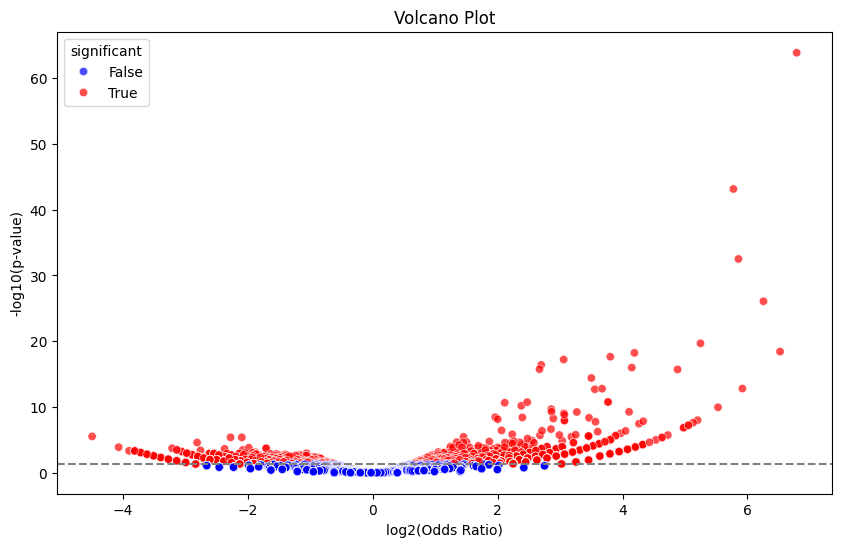

In [54]:
# Creëer een figuur en een as
plt.figure(figsize=(10, 6))

# Maak de volcano plot
sns.scatterplot(data=fisher_exact_results_df, 
                 x='log2_odds_ratio', 
                 y='neg_log10_p_value', 
                 hue='significant',  # Gebruik de nieuwe kolom voor kleuren
                 palette={True: 'red', False: 'blue'},  # Rood voor significant, blauw voor niet-significant
                 alpha=0.7)

# Voeg een horizontale lijn toe voor de drempel (bijv. p < 0.05)
plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--')

# Labels en titel
plt.title('Volcano Plot')
plt.xlabel('log2(Odds Ratio)')
plt.ylabel('-log10(p-value)')

# Toon de plot
plt.show()



In [21]:
# # Filter de DataFrame om alleen rijen met p-value < 0.05 te behouden
# significant_results = fisher_exact_results_df[fisher_exact_results_df['p_value'] < 0.05]

# # Bekijk de gefilterde resultaten
# significant_results

In [ ]:
#lijst met tcr's van trainingset gebruiken om te zien hoe vaak die voorkomt in validatiedataset (resterende 266 patienten), 
#in welke personen ze voorkomen en plot maken van emerson paper (percentage)


# maak een simpele classifier, zoals logistische regressie, eenvoudigste machine learning model is een treshold
# features: aantal 

#### Check for significant TCR in given list 

In [55]:
#load given list of significant tcr's
significant_tcr_df = pd.read_csv(path + "//significant_tcrs.tsv", sep='\t')
significant_tcr_df

,Row,TCR+V,p_BH,TCR_sharing,HLA $\cap$ TCRs,HLA,chain,Attribute,v_call,junction_aa
0,2868,CASSIRSSYEQYF+TRBV19,5.828883e-93,322.0,286.0,A*02:01,beta,Overrepresented,CASSIRSSYEQYF,TRBV19
1,2869,CSVGTGGTNEKLFF+TRBV29,1.738559e-84,250.0,236.0,A*02:01,beta,Overrepresented,CSVGTGGTNEKLFF,TRBV29
2,2870,CASSIRSAYEQYF+TRBV19,7.512673e-50,166.0,157.0,A*02:01,beta,Overrepresented,CASSIRSAYEQYF,TRBV19
3,2871,CSARDGTGNGYTF+TRBV20,7.504383e-47,138.0,135.0,A*02:01,beta,Overrepresented,CSARDGTGNGYTF,TRBV20
4,2872,CSARDRTGNGYTF+TRBV20,8.746265e-45,148.0,141.0,A*02:01,beta,Overrepresented,CSARDRTGNGYTF,TRBV20
5,2874,CASSEDGMNTEAFF+TRBV10,2.097653e-38,120.0,117.0,A*02:01,beta,Overrepresented,CASSEDGMNTEAFF,TRBV10
6,2876,CSVGSGGTNEKLFF+TRBV29,5.579374e-35,111.0,108.0,A*02:01,beta,Overrepresented,CSVGSGGTNEKLFF,TRBV29
7,2877,CASSVRSSYEQYF+TRBV19,6.370092e-35,108.0,106.0,A*02:01,beta,Overrepresented,CASSVRSSYEQYF,TRBV19
8,2879,CASSQSPGGTQYF+TRBV14,1.754853e-34,107.0,105.0,A*02:01,beta,Overrepresented,CASSQSPGGTQYF,TRBV14
9,2880,CASSLEGQASSYEQYF+TRBV5,4.462534e-34,113.0,109.0,A*02:01,beta,Overrepresented,CASSLEGQASSYEQYF,TRBV5


In [56]:
columns_to_keep = ['TCR+V', 'HLA', 'v_call', 'junction_aa', 'Attribute']
significant_tcr_df = significant_tcr_df[columns_to_keep]
significant_tcr_df = significant_tcr_df.rename(columns={'v_call': 'junction_aa', 'junction_aa': 'v_call'})
significant_tcr_df

,TCR+V,HLA,junction_aa,v_call,Attribute
0,CASSIRSSYEQYF+TRBV19,A*02:01,CASSIRSSYEQYF,TRBV19,Overrepresented
1,CSVGTGGTNEKLFF+TRBV29,A*02:01,CSVGTGGTNEKLFF,TRBV29,Overrepresented
2,CASSIRSAYEQYF+TRBV19,A*02:01,CASSIRSAYEQYF,TRBV19,Overrepresented
3,CSARDGTGNGYTF+TRBV20,A*02:01,CSARDGTGNGYTF,TRBV20,Overrepresented
4,CSARDRTGNGYTF+TRBV20,A*02:01,CSARDRTGNGYTF,TRBV20,Overrepresented
5,CASSEDGMNTEAFF+TRBV10,A*02:01,CASSEDGMNTEAFF,TRBV10,Overrepresented
6,CSVGSGGTNEKLFF+TRBV29,A*02:01,CSVGSGGTNEKLFF,TRBV29,Overrepresented
7,CASSVRSSYEQYF+TRBV19,A*02:01,CASSVRSSYEQYF,TRBV19,Overrepresented
8,CASSQSPGGTQYF+TRBV14,A*02:01,CASSQSPGGTQYF,TRBV14,Overrepresented
9,CASSLEGQASSYEQYF+TRBV5,A*02:01,CASSLEGQASSYEQYF,TRBV5,Overrepresented


In [57]:
fisher_columns = ['TCR', 'odds_ratio', 'p_value']
fisher_exact_results_df_copy = fisher_exact_results_df[fisher_columns]
fisher_exact_results_df_copy

,TCR,odds_ratio,p_value
0,"(TRBV5-1, CASSLRGSGNTIYF, TRBJ1-3)",1.168750,0.633815
1,"(TRBV4-2, CASSQEGQSSYEQYF, TRBJ2-7)",0.982258,1.000000
2,"(TRBV6-5, CASSYSGSNQPQHF, TRBJ1-5)",0.970109,0.916120
3,"(TRBV6-5, CASSYYGTAQETQYF, TRBJ2-5)",0.650943,0.701900
4,"(TRBV6-4, CASSDNSGANVLTF, TRBJ2-6)",0.946849,0.830762
...,...,...,...
1007240,"(TRBV5-1, CASSLSGQNEKLFF, TRBJ1-4)",1.314465,1.000000
1007241,"(TRBV7-6, CASSLAGPSSGNTIYF, TRBJ1-3)",0.000000,0.136572
1007242,"(TRBV12-5, CASGHQETQYF, TRBJ2-5)",1.984177,0.655966
1007243,"(TRBV18, CASSPTGIYNEQFF, TRBJ2-1)",0.872117,1.000000


In [58]:
fisher_exact_results_df_copy[['v_call', 'junction_aa', 'j_call']] = pd.DataFrame(
    fisher_exact_results_df_copy['TCR'].tolist(), index=fisher_exact_results_df_copy.index
)

# Maak de 'TCR+V'-kolom door 'v_call' en 'junction_aa' te combineren
fisher_exact_results_df_copy['TCR+V'] = fisher_exact_results_df_copy['junction_aa'] + "+" + fisher_exact_results_df_copy['v_call']  

C:\Users\fried\AppData\Local\Temp\ipykernel_2440\2169312115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fisher_exact_results_df_copy[['v_call', 'junction_aa', 'j_call']] = pd.DataFrame(
C:\Users\fried\AppData\Local\Temp\ipykernel_2440\2169312115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fisher_exact_results_df_copy[['v_call', 'junction_aa', 'j_call']] = pd.DataFrame(
C:\Users\fried\AppData\Local\Temp\ipykernel_2440\2169312115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a 

In [59]:
fisher_exact_results_df_copy['v_call'] = fisher_exact_results_df_copy['v_call'].str.split('-').str[0]
fisher_exact_results_df_copy

C:\Users\fried\AppData\Local\Temp\ipykernel_2440\2956598323.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fisher_exact_results_df_copy['v_call'] = fisher_exact_results_df_copy['v_call'].str.split('-').str[0]


,TCR,odds_ratio,p_value,v_call,junction_aa,j_call,TCR+V
0,"(TRBV5-1, CASSLRGSGNTIYF, TRBJ1-3)",1.168750,0.633815,TRBV5,CASSLRGSGNTIYF,TRBJ1-3,CASSLRGSGNTIYF+TRBV5-1
1,"(TRBV4-2, CASSQEGQSSYEQYF, TRBJ2-7)",0.982258,1.000000,TRBV4,CASSQEGQSSYEQYF,TRBJ2-7,CASSQEGQSSYEQYF+TRBV4-2
2,"(TRBV6-5, CASSYSGSNQPQHF, TRBJ1-5)",0.970109,0.916120,TRBV6,CASSYSGSNQPQHF,TRBJ1-5,CASSYSGSNQPQHF+TRBV6-5
3,"(TRBV6-5, CASSYYGTAQETQYF, TRBJ2-5)",0.650943,0.701900,TRBV6,CASSYYGTAQETQYF,TRBJ2-5,CASSYYGTAQETQYF+TRBV6-5
4,"(TRBV6-4, CASSDNSGANVLTF, TRBJ2-6)",0.946849,0.830762,TRBV6,CASSDNSGANVLTF,TRBJ2-6,CASSDNSGANVLTF+TRBV6-4
...,...,...,...,...,...,...,...
1007240,"(TRBV5-1, CASSLSGQNEKLFF, TRBJ1-4)",1.314465,1.000000,TRBV5,CASSLSGQNEKLFF,TRBJ1-4,CASSLSGQNEKLFF+TRBV5-1
1007241,"(TRBV7-6, CASSLAGPSSGNTIYF, TRBJ1-3)",0.000000,0.136572,TRBV7,CASSLAGPSSGNTIYF,TRBJ1-3,CASSLAGPSSGNTIYF+TRBV7-6
1007242,"(TRBV12-5, CASGHQETQYF, TRBJ2-5)",1.984177,0.655966,TRBV12,CASGHQETQYF,TRBJ2-5,CASGHQETQYF+TRBV12-5
1007243,"(TRBV18, CASSPTGIYNEQFF, TRBJ2-1)",0.872117,1.000000,TRBV18,CASSPTGIYNEQFF,TRBJ2-1,CASSPTGIYNEQFF+TRBV18


In [60]:
# Merge de twee DataFrames op basis van de kolom 'TCR+V'
merged_df = pd.merge(fisher_exact_results_df_copy, significant_tcr_df, on='TCR+V', how='inner')
merged_df.sort_values(by=["p_value"])

,TCR,odds_ratio,p_value,v_call_x,junction_aa_x,j_call,TCR+V,HLA,junction_aa_y,v_call_y,Attribute
6,"(TRBV19, CASSIRSSYEQYF, TRBJ2-7)",110.449219,1.357582e-64,TRBV19,CASSIRSSYEQYF,TRBJ2-7,CASSIRSSYEQYF+TRBV19,A*02:01,CASSIRSSYEQYF,TRBV19,Overrepresented
10,"(TRBV19, CASSIRSAYEQYF, TRBJ2-7)",57.878289,3.098171e-33,TRBV19,CASSIRSAYEQYF,TRBJ2-7,CASSIRSAYEQYF+TRBV19,A*02:01,CASSIRSAYEQYF,TRBV19,Overrepresented
21,"(TRBV19, CASSVRSSYEQYF, TRBJ2-7)",76.408602,8.462878e-27,TRBV19,CASSVRSSYEQYF,TRBJ2-7,CASSVRSSYEQYF+TRBV19,A*02:01,CASSVRSSYEQYF,TRBV19,Overrepresented
7,"(TRBV19, CASSIRSSYEQYF, TRBJ2-5)",inf,1.161552e-20,TRBV19,CASSIRSSYEQYF,TRBJ2-5,CASSIRSSYEQYF+TRBV19,A*02:01,CASSIRSSYEQYF,TRBV19,Overrepresented
9,"(TRBV19, CASSGRSTDTQYF, TRBJ2-3)",38.000000,2.154700e-20,TRBV19,CASSGRSTDTQYF,TRBJ2-3,CASSGRSTDTQYF+TRBV19,A*02:01,CASSGRSTDTQYF,TRBV19,Overrepresented
23,"(TRBV19, CASSTRSSYEQYF, TRBJ2-7)",18.251082,5.924888e-19,TRBV19,CASSTRSSYEQYF,TRBJ2-7,CASSTRSSYEQYF+TRBV19,A*02:01,CASSTRSSYEQYF,TRBV19,Overrepresented
16,"(TRBV19, CASSSRSSYEQYF, TRBJ2-7)",13.964211,2.302283e-18,TRBV19,CASSSRSSYEQYF,TRBJ2-7,CASSSRSSYEQYF+TRBV19,A*02:01,CASSSRSSYEQYF,TRBV19,Overrepresented
12,"(TRBV9, CASSVGGGTYEQYF, TRBJ2-7)",6.487407,4.003948e-17,TRBV9,CASSVGGGTYEQYF,TRBJ2-7,CASSVGGGTYEQYF+TRBV9,A*02:01,CASSVGGGTYEQYF,TRBV9,Overrepresented
19,"(TRBV9, CASSVGGDYGYTF, TRBJ1-2)",6.367188,1.781895e-16,TRBV9,CASSVGGDYGYTF,TRBJ1-2,CASSVGGDYGYTF+TRBV9,A*02:01,CASSVGGDYGYTF,TRBV9,Overrepresented
27,"(TRBV14, CASSQSPGGIQYF, TRBJ2-4)",inf,9.225446e-16,TRBV14,CASSQSPGGIQYF,TRBJ2-4,CASSQSPGGIQYF+TRBV14,A*02:01,CASSQSPGGIQYF,TRBV14,Overrepresented


### Use the validation patients (266 patients) and match/count the HLA-02.01 related TCR's for every patient

##### make a table with 3 columns: patient, #total TCR's and #HLA-02.01 related TCR's (from the fisher_exact_results_df where p-value < 0.05)

In [76]:
related_tcrs = fisher_exact_results_df[(fisher_exact_results_df['p_value'] < 0.05) & (fisher_exact_results_df['odds_ratio'] > 1)].reset_index(drop=True)
related_tcrs

,HLA,TCR,odds_ratio,p_value,have_hla_and_tcr,have_no_hla_and_tcr,have_hla_no_tcr,have_no_hla_no_tcr,log2_odds_ratio,neg_log10_p_value,significant
0,HLA-A*02:01,"(TRBV4-1, CASSQVGETQYF, TRBJ2-5)",1.709457,3.602553e-02,47.1,41.1,114.1,170.1,0.773538,1.443390,True
1,HLA-A*02:01,"(TRBV19, CASSTGVYGYTF, TRBJ1-2)",2.506732,3.559138e-03,32.1,19.1,129.1,192.1,1.325808,2.448655,True
2,HLA-A*02:01,"(TRBV9, CASSVGGGTEAFF, TRBJ1-1)",8.339869,9.145735e-10,154.1,153.1,7.1,58.1,3.060025,9.038781,True
3,HLA-A*02:01,"(TRBV6-5, CASSYSEVSGNTIYF, TRBJ1-3)",8.129032,4.585036e-02,6.1,1.1,155.1,210.1,3.023084,1.338657,True
4,HLA-A*02:01,"(TRBV27, CASSHRDSNQPQHF, TRBJ1-5)",2.031250,4.114176e-02,23.1,16.1,138.1,195.1,1.022368,1.385717,True
...,...,...,...,...,...,...,...,...,...,...,...
21984,HLA-A*02:01,"(TRBV6-5, CASSYGPGGNYGYTF, TRBJ1-2)",inf,3.434434e-02,4.1,0.1,157.1,211.1,inf,1.464145,True
21985,HLA-A*02:01,"(TRBV10-2, CASRDRGDTEAFF, TRBJ1-1)",inf,1.465234e-02,5.1,0.1,156.1,211.1,inf,1.834093,True
21986,HLA-A*02:01,"(TRBV19, CASSINSGSYEQYF, TRBJ2-7)",inf,6.228242e-03,6.1,0.1,155.1,211.1,inf,2.205635,True
21987,HLA-A*02:01,"(TRBV7-9, CASSFAGGSTDTQYF, TRBJ2-3)",inf,6.228242e-03,6.1,0.1,155.1,211.1,inf,2.205635,True


In [77]:
files_path = path + '\\data\\HLA_emerson_2017'

all_files = os.listdir(files_path)

tsv_gz_files_validation = [f for f in all_files if f.endswith('.tsv.gz')]

tsv_gz_files_validation = tsv_gz_files_validation[400:]

patient_names_validation = [f.split('.')[0] for f in tsv_gz_files_validation]

In [78]:
top_tcrs = [50, 100 , 500, 1000, 2000, 5000, len(related_tcrs)]

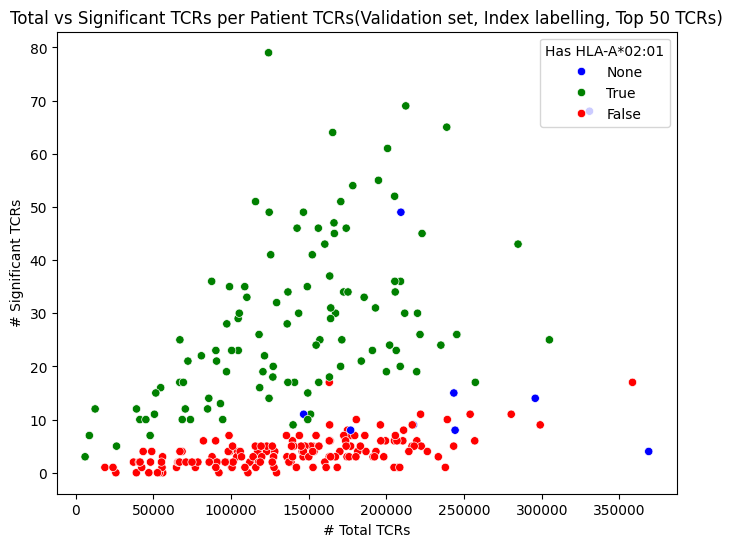

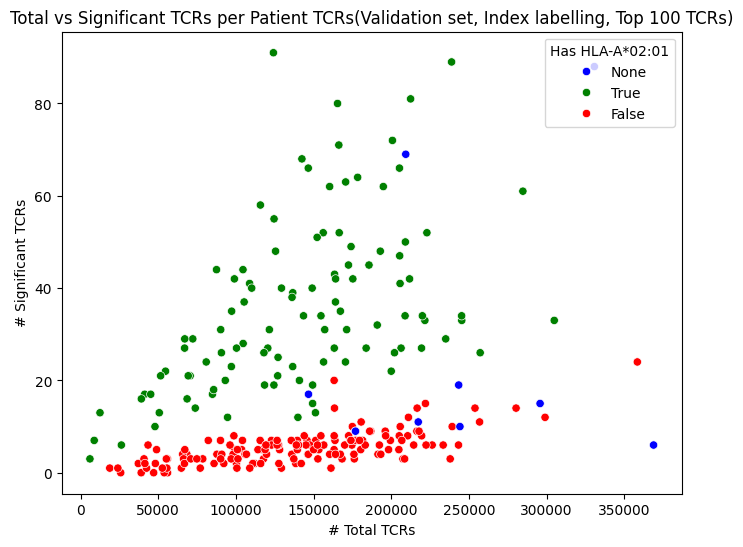

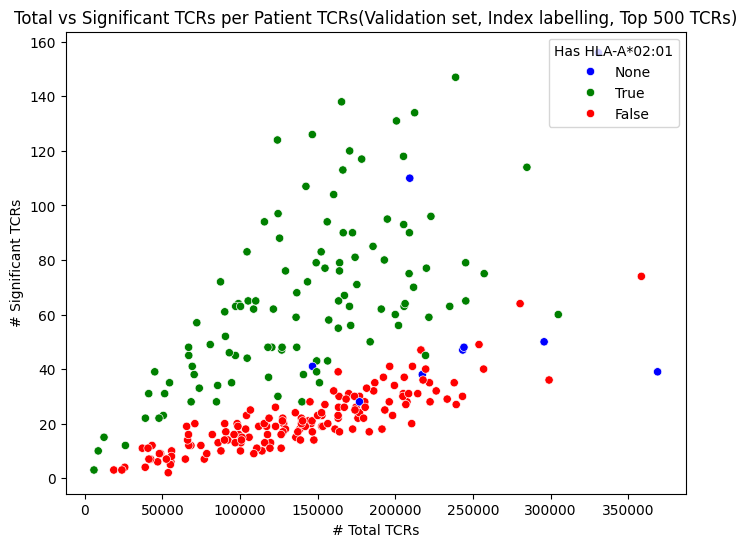

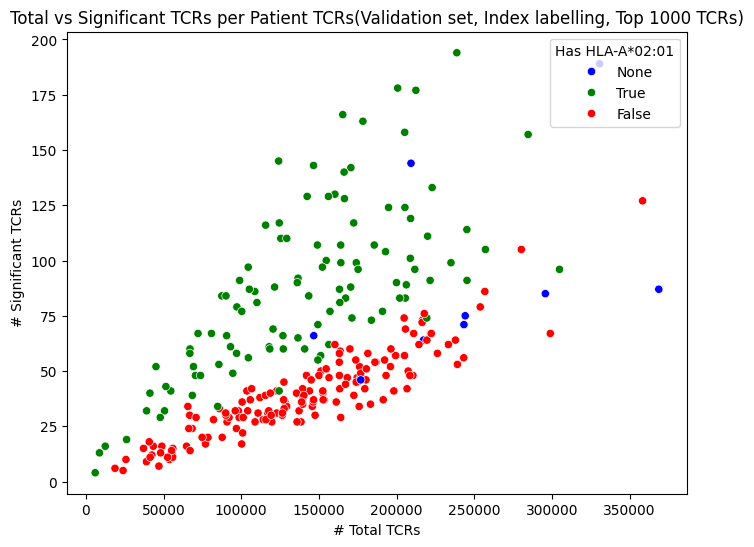

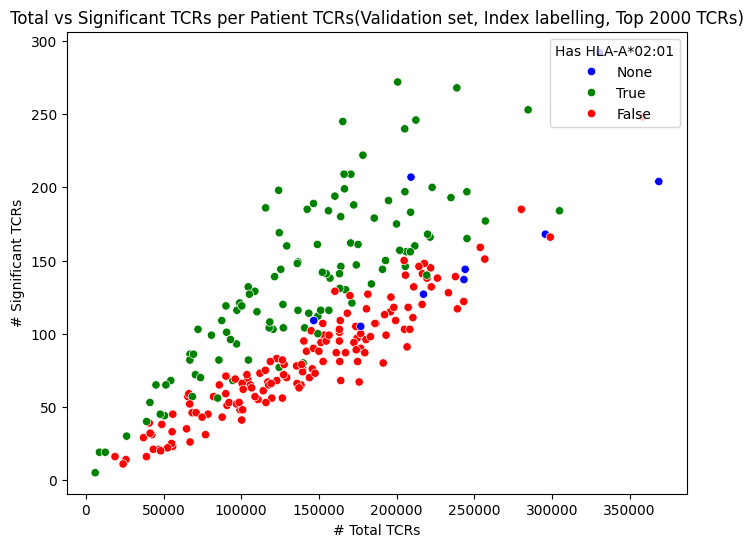

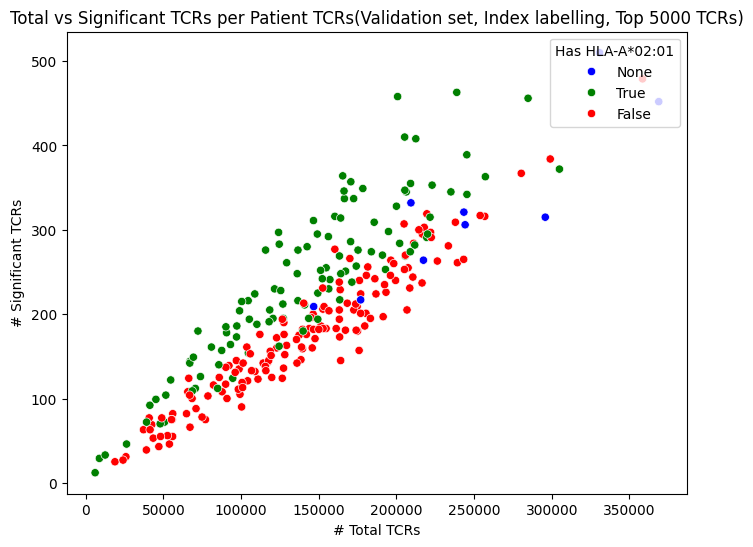

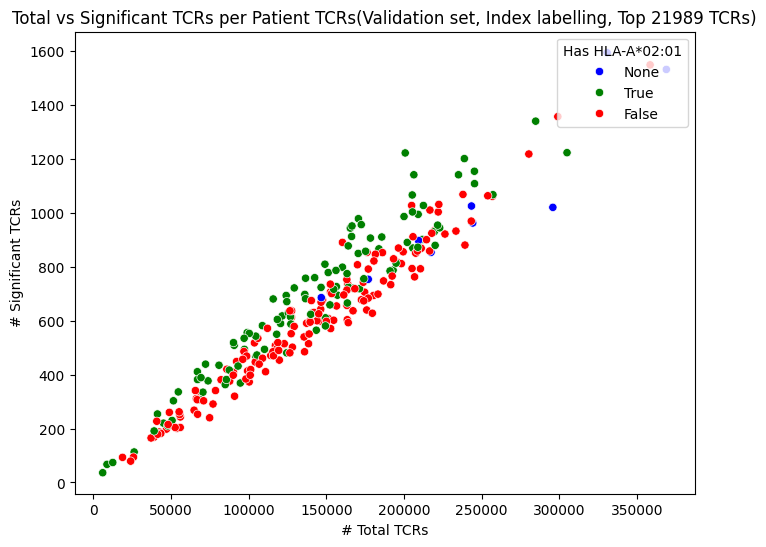

In [80]:
#patient_hla_labeling = pd.read_csv(path + "\\data\\emerson_hla_a0201.csv")
#patient_hla_labeling.rename(columns={'sample_name': 'repertoire_id'}, inplace=True)

# Add '_clonotype' to every row in the column reperotire_id
#patient_hla_labeling['repertoire_id'] = patient_hla_labeling['repertoire_id'] + '_clonotypes'

patient_hla_labeling = patient_df.copy()

# Stel de kleuren in voor de categorieën
palette = {True: 'green', False: 'red', 'None': 'blue'}

for x in top_tcrs:
    validation_df = pd.DataFrame(columns=['repertoire_id', 'total_tcrs', 'related_tcrs'])
    validation_data = []
    top_related_tcrs = related_tcrs.sort_values(by=["p_value"]).head(x)
    for f in tsv_gz_files_validation:
        file_path = os.path.join(files_path, f)
        with gzip.open(file_path, 'rt') as fi:
            # Inlezen als pandas DataFrame
            df = pd.read_csv(fi, sep='\t')
            
            # Controleer of DataFrame niet leeg is
            if df.empty:
                continue
            
            # Voeg de TCR-combinaties toe als tuple
            if {'v_call', 'junction_aa', 'j_call'}.issubset(df.columns):
                df['TCR'] = [tuple(tcr) for tcr in zip(df['v_call'], df['junction_aa'], df['j_call'])]            
            else:
                continue  # Sla over als de vereiste kolommen ontbreken
            
            # Voeg de TCR-combinaties toe als tuple
            #if {'v_call', 'junction_aa', 'j_call'}.issubset(df.columns):
                #df['v_call'] =  df['v_call'].str.split('-').str[0]
                #df['TCR+V'] = df['junction_aa'] + '+' + df['v_call']          
            #else:
                #continue  # Sla over als de vereiste kolommen ontbreken
            

            # Haal totalen op
            total_tcrs = len(df)
            rep_id = df['repertoire_id'].iloc[0]  # Gebruik .iloc om een fout te voorkomen

            # check if value of HLA-A*02:01 is NaN
            has_hla = None
            hla_row = patient_hla_labeling[patient_hla_labeling['repertoire_id'] == rep_id]
            if not hla_row.empty:
                has_hla = hla_row['has_HLA_A02_01'].iloc[0]
            #if hla is NaN value, change to None
            if pd.isna(has_hla):  # Controleer of de waarde NaN is
                has_hla = None
        
            
            # Zoek naar matches met de significante TCRs
            #matching_tcrs = df[df['TCR'].isin(top_related_tcrs['TCR'])].shape[0]

            matching_tcrs = df[df['TCR'].isin(top_related_tcrs['TCR'])].shape[0]
            #matching_tcrs = df[df['TCR+V'].isin(significant_tcr_df['TCR+V'])].shape[0]
        
            
            # Voeg de resultaten toe aan de lijst
            validation_data.append({
                'repertoire_id': rep_id,
                '# Total TCRs': total_tcrs,
                '# Significant TCRs': matching_tcrs,
                'has_HLA_A02_01': has_hla
            })

    # Als je de data als een DataFrame wilt hebben
    validation_df = pd.DataFrame(validation_data)

    # Zorg ervoor dat de kolom consistente typen heeft
    # Zet None om naar een string 'None'
    validation_df['has_HLA_A02_01'] = validation_df['has_HLA_A02_01'].map(
        {True: True, False: False, None: 'None'}
    )
    # Zorg ervoor dat de kolom consistente typen heeft

    plt.figure(figsize=(8, 6))  # Stel de grootte van de plot in

    # Maak de scatterplot met juiste kleurtoewijzing
    sns.scatterplot(
        x=validation_df['# Total TCRs'], 
        y=validation_df['# Significant TCRs'], 
        hue=validation_df['has_HLA_A02_01'],  # Gebruik de aangepaste kolom voor 'hue'
        palette=palette  # Geef kleuren op via het palette
    )

    # Voeg labels en titel toe
    plt.xlabel('# Total TCRs')
    plt.ylabel('# Significant TCRs')
    plt.title('Total vs Significant TCRs per Patient TCRs(Validation set, Index labelling, Top ' + str(x) + ' TCRs)')

    # Toon de legenda correct
    plt.legend(title='Has HLA-A*02:01', loc='upper right')

    #Sla plot op in results folder
    plt.savefig('results\\Total vs Significant TCRs per Patient_TCRs(Validation set, Index labelling, Top ' + str(x) + ' TCRs)')

    # Toon de plot
    plt.show()

#### Apply Benjamini-Hochberg False discovery control on training dataset

In [81]:
## Benjamin houberg van scipy (false discovery control)

# Voer de Benjamini-Hochberg correctie uit op de p-waarden
benjamini_hochberg_results = fisher_exact_results_df.copy()
benjamini_hochberg_results = benjamini_hochberg_results.sort_values(by='p_value').reset_index(drop=True)
benjamini_hochberg_results['BH'] = benjamini_hochberg_results['p_value'] * len(benjamini_hochberg_results) / (benjamini_hochberg_results.index + 1)





In [82]:
benjamini_hochberg_results

,HLA,TCR,odds_ratio,p_value,have_hla_and_tcr,have_no_hla_and_tcr,have_hla_no_tcr,have_no_hla_no_tcr,log2_odds_ratio,neg_log10_p_value,significant,BH
0,HLA-A*02:01,"(TRBV19, CASSIRSSYEQYF, TRBJ2-7)",110.449219,1.357582e-64,145.1,16.1,16.1,195.1,6.787239,63.867234,True,1.367418e-58
1,HLA-A*02:01,"(TRBV29-1, CSVGTGGTNEKLFF, TRBJ1-4)",54.730392,7.037225e-44,110.1,8.1,51.1,203.1,5.774270,43.152599,True,3.544105e-38
2,HLA-A*02:01,"(TRBV19, CASSIRSAYEQYF, TRBJ2-7)",57.878289,3.098171e-33,85.1,4.1,76.1,207.1,5.854950,32.508895,True,1.040206e-27
3,HLA-A*02:01,"(TRBV19, CASSVRSSYEQYF, TRBJ2-7)",76.408602,8.462878e-27,68.1,2.1,93.1,209.1,6.255663,26.072482,True,2.131048e-21
4,HLA-A*02:01,"(TRBV19, CASSIRSSYEQYF, TRBJ2-5)",inf,1.161552e-20,49.1,0.1,112.1,211.1,inf,19.934961,True,2.339935e-15
...,...,...,...,...,...,...,...,...,...,...,...,...
1007240,HLA-A*02:01,"(TRBV27, CASSLSGTGVNEQFF, TRBJ2-1)",1.314465,1.000000e+00,2.1,2.1,159.1,209.1,0.394476,-0.000000,False,1.000004e+00
1007241,HLA-A*02:01,"(TRBV27, CASSITGTYEQYF, TRBJ2-7)",0.872117,1.000000e+00,2.1,3.1,159.1,208.1,-0.197406,-0.000000,False,1.000003e+00
1007242,HLA-A*02:01,"(TRBV2, CASSGYEQYF, TRBJ2-5)",1.020202,1.000000e+00,7.1,9.1,154.1,202.1,0.028855,-0.000000,False,1.000002e+00
1007243,HLA-A*02:01,"(TRBV7-8, CASSLGRDEQFF, TRBJ2-1)",0.782278,1.000000e+00,3.1,5.1,158.1,206.1,-0.354246,-0.000000,False,1.000001e+00


In [56]:
from statsmodels.stats.multitest import multipletests
# Voer de correctie uit
adjusted_p_values = multipletests(
    fisher_exact_results_df['p_value'], 
    method='fdr_bh'
)[1]

fisher_exact_results_df['p_value_adjusted'] = adjusted_p_values
fisher_exact_results_df.sort_values(by=["p_value_adjusted"])

,HLA,TCR,odds_ratio,p_value,have_hla_and_tcr,have_no_hla_and_tcr,have_hla_no_tcr,have_no_hla_no_tcr,log2_odds_ratio,neg_log10_p_value,significant,p_value_adjusted
0,HLA-A*02:01,"(TRBV5-1, CASSLRGSGNTIYF, TRBJ1-3)",0.664139,0.254440,15.1,28.1,146.1,181.1,-0.590443,0.594414,False,1.0
671488,HLA-A*02:01,"(TRBV2, CASGQGANTGELFF, TRBJ2-2)",1.749469,0.474355,4.1,3.1,157.1,206.1,0.806917,0.323897,False,1.0
671489,HLA-A*02:01,"(TRBV5-4, CASSLAQGEQYF, TRBJ2-7)",0.863732,1.000000,2.1,3.1,159.1,206.1,-0.211345,-0.000000,False,1.0
671490,HLA-A*02:01,"(TRBV5-1, CASSTGPYEQYF, TRBJ2-7)",6.128289,0.012107,9.1,2.1,152.1,207.1,2.615484,1.916959,True,1.0
671491,HLA-A*02:01,"(TRBV4-2, CASSQDGQGNTEAFF, TRBJ1-1)",0.861996,1.000000,4.1,6.1,157.1,203.1,-0.214247,-0.000000,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
335753,HLA-A*02:01,"(TRBV5-1, CASSLGAGKNTEAFF, TRBJ1-1)",0.973101,1.000000,3.1,4.1,158.1,205.1,-0.039338,-0.000000,False,1.0
335754,HLA-A*02:01,"(TRBV28, CASSFGGNYEQYF, TRBJ2-7)",0.477057,0.361142,3.1,8.1,158.1,201.1,-1.067767,0.442321,False,1.0
335755,HLA-A*02:01,"(TRBV28, CASSFGVTDTQYF, TRBJ2-3)",1.965190,0.656519,3.1,2.1,158.1,207.1,0.974669,0.182753,False,1.0
335757,HLA-A*02:01,"(TRBV14, CASSQVRNEQFF, TRBJ2-1)",0.640127,0.563102,4.1,8.1,157.1,201.1,-0.643569,0.249413,False,1.0
